In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
path = os.getcwd()+"/AigisResults"
saving_path = os.getcwd()+"/WriteUp/Plots/"
sys.path.append(path)
sys.path.append(saving_path)
import pickle
from QuantumNetworkEnvsClean import QuantumNetworkPWC
from scipy.fft import rfft, irfft, rfftfreq
rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
}
mpl.rcParams.update(rc_fonts)

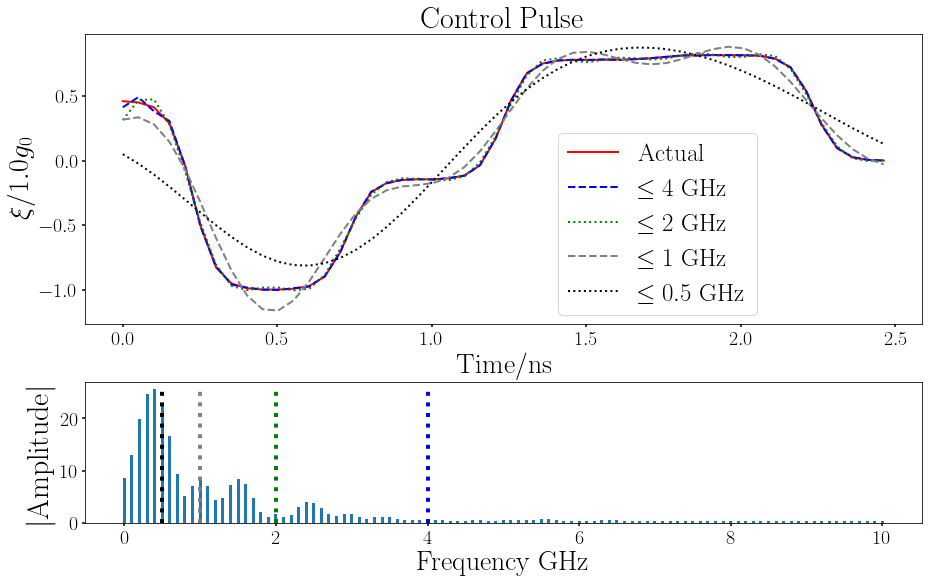

In [44]:
stname='Dicke3_2'
load_path = path+"/ModifiedReward/{}/Trial1/Best".format(stname)

resolution=10
best_chromosome = np.loadtxt(load_path+"/chromosome")
with open(load_path+"/env", 'rb') as pickle_file:
    original_env = pickle.load(pickle_file)   
dimension=original_env.cav_dim
env = QuantumNetworkPWC(N_qubits=original_env.N, N_steps=original_env.N_steps,
                                 max_time=original_env.max_time, cav_dim=dimension,
                                 resolution=resolution, max_coupling=original_env.max_coupling/original_env.g,
                                 max_driving=original_env.max_driving/original_env.g,
                                init_state=original_env.init_state, targ_state=original_env.targ_state_ket,
                                save_path=load_path, sharpness=original_env.sharpness)

edited_chrome = np.copy(best_chromosome)
chrome = np.hsplit(edited_chrome,env.N_controls)
cut_off_index = 5
for i in range(env.N_controls):
    chrome[i][cut_off_index:] = 0
new_best_chromosome = np.concatenate(chrome) 
env.plot_initializer(new_best_chromosome)
res_cut_off_index = cut_off_index*env.resolution
times = env.times
full_pulse = env.decode_actions_pwc(new_best_chromosome)




def real_fourier_tf(pulse, times, resolution, n_steps, trunc=10):
    N = times.shape[0]
    T = times[-1]
    sample_rate = int(resolution/(T/n_steps))
    x = np.linspace(0, T, N, endpoint=True)
    y = rfft(pulse)
    xf = rfftfreq(N, 1 / sample_rate)
    # Truncate the frequency at 5Ghz
    truncated_yf = np.copy(y)
    truncated_yf[int(trunc*sample_rate):]=0.
    processed_pulse = irfft(truncated_yf)
    return np.abs(truncated_yf), xf, processed_pulse
    
# # Run dynamics to get best index
names = env.qubit_names
title_label = env.control
plt.figure(100, figsize=(15,9))
# n_rows=2*int(np.ceil(env.N_controls/2))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(10,1)
ax1 = plt.subplot(gs[:6, 0])
ax2 = plt.subplot(gs[7:, 0])
# for idx, name in enumerate(env.qubit_names):
#     freq, freqx, processed_pulse = real_fourier_tf(full_pulse[0][name][:], env.times, env.resolution, env.N_steps)
#     axes[2*(idx//2), idx%2].plot(times, processed_pulse/env.g, linewidth=2)
#     axes[2*(idx//2), idx%2].set_title("{} {}".format(name, title_label), fontsize=20)
#     axes[2*(idx//2), idx%2].set_ylabel(r"${} /g_0$".format(title_label), fontsize=20)
#     axes[2*(idx//2), idx%2].set_xlabel("Time/ns", fontsize=20)
#     axes[2*(idx//2), idx%2].tick_params(labelsize=12, width=1.5, length=3)
#     axes[2*(idx//2) + 1, idx%2].bar(freqx, freq, width=0.04)
#     axes[2*(idx//2) + 1, idx%2].tick_params(labelsize=12, width=1.5, length=3)
#     axes[2*(idx//2) + 1, idx%2].set_xlabel("Frequency {GHz}", fontsize=20)
#     axes[2*(idx//2) + 1, idx%2].set_ylabel("|Amplitude|", fontsize=20)
freq, freqx, processed_pulse2 = real_fourier_tf(full_pulse[1][:], env.times, env.resolution, env.N_steps, trunc=0.5)
freq, freqx, processed_pulse4 = real_fourier_tf(full_pulse[1][:], env.times, env.resolution, env.N_steps, trunc=1)
freq, freqx, processed_pulse6 = real_fourier_tf(full_pulse[1][:], env.times, env.resolution, env.N_steps, trunc=2)
freq, freqx, processed_pulse8 = real_fourier_tf(full_pulse[1][:], env.times, env.resolution, env.N_steps, trunc=4)
freq, freqx, processed_pulse10 = real_fourier_tf(full_pulse[1][:], env.times, env.resolution, env.N_steps, trunc=10)
ax1.plot(times[:res_cut_off_index], full_pulse[1][:res_cut_off_index]/(env.max_driving), linewidth=2,
        color='r', linestyle="-", label="Actual")
ax1.plot(times[:res_cut_off_index], processed_pulse8[:res_cut_off_index]/(env.max_driving), linewidth=2,
            linestyle="--", color='b',  label="$\leq 4$ GHz")
ax1.plot(times[:res_cut_off_index], processed_pulse6[:res_cut_off_index]/(env.max_driving), linewidth=2,
            linestyle=":", color='green', label="$\leq 2$ GHz")
ax1.plot(times[:res_cut_off_index], processed_pulse4[:res_cut_off_index]/(env.max_driving), linewidth=2,
            linestyle="--", color='grey', label="$\leq 1$ GHz")
ax1.plot(times[:res_cut_off_index], processed_pulse2[:res_cut_off_index]/(env.max_driving), linewidth=2,
            linestyle=":", color='k', label="$\leq 0.5$ GHz")
ax1.set_title("Control Pulse", fontsize=30)
ax1.set_xlabel("Time/ns", fontsize=28)
ax1.set_ylabel(r"$\xi  /{} g_0$".format(np.round(env.max_driving/env.g, decimals=2)), fontsize=28)
ax1.tick_params(labelsize=12, width=1.5, length=3)
ax1.legend(fontsize=25, loc='best', bbox_to_anchor=(0.55, 0.7))
ax2.vlines(0.5, ymin=0, ymax=np.max(freq), color='k', linestyle=':', linewidth=4)
ax2.vlines(1, ymin=0, ymax=np.max(freq), color='grey', linestyle=':', linewidth=4)
ax2.vlines(2, ymin=0, ymax=np.max(freq), color='green', linestyle=':', linewidth=4)
ax2.vlines(4, ymin=0, ymax=np.max(freq), color='b', linestyle=':', linewidth=4)
ax2.bar(freqx, freq, width=0.04)
ax2.tick_params(labelsize=12, width=1.5, length=3)
ax2.set_xlabel("Frequency {GHz}", fontsize=28)
ax2.set_ylabel(r"$|$Amplitude$|$", fontsize=30)
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
# if (idx+2)%2==1:
#     axes[2*((idx+1)//2), (idx+2)%2].axis('off')
#     axes[2*((idx+1)//2) + 1,(idx+2)%2].axis('off')# plt.savefig(load_path+"/Control_Plots", dpi=600, layout='tight')
plt.savefig(saving_path+"FourierAnalysis", layout="tight", dpi=300)